In [1]:
import pandas as pd

df = pd.read_csv("train_hsbc_df.csv")
df.head(-50)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C583110837','3','M','28007','M480139044','28007','es_health',44.26,1
1,0,'C1332295774','3','M','28007','M480139044','28007','es_health',324.50,1
2,0,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices',176.32,1
3,0,'C966214713','3','M','28007','M857378720','28007','es_hotelservices',337.41,1
4,0,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty',220.11,1
...,...,...,...,...,...,...,...,...,...,...
513588,179,'C827350474','4','F','28007','M85975013','28007','es_food',62.62,0
513589,179,'C1151051721','3','M','28007','M1823072687','28007','es_transportation',34.50,0
513590,179,'C1621267054','2','F','28007','M85975013','28007','es_food',1.30,0
513591,179,'C897612698','4','M','28007','M348934600','28007','es_transportation',27.05,0


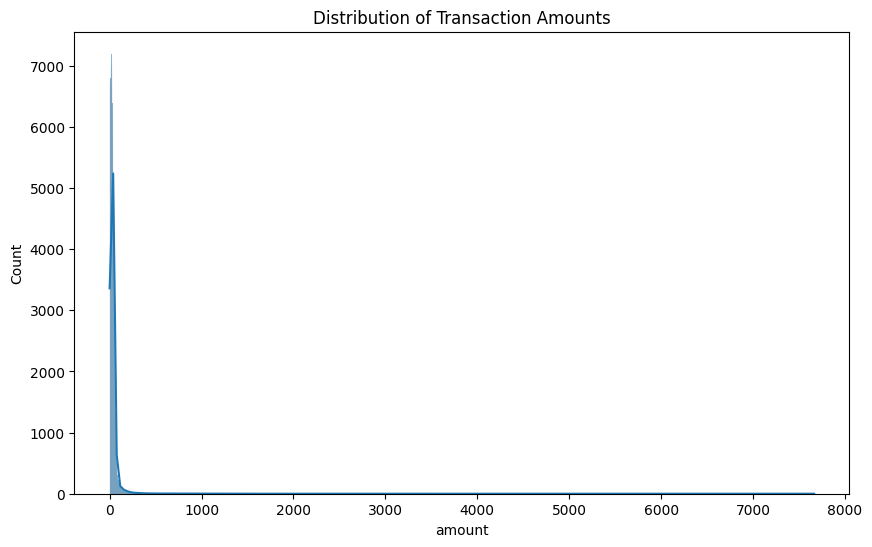

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

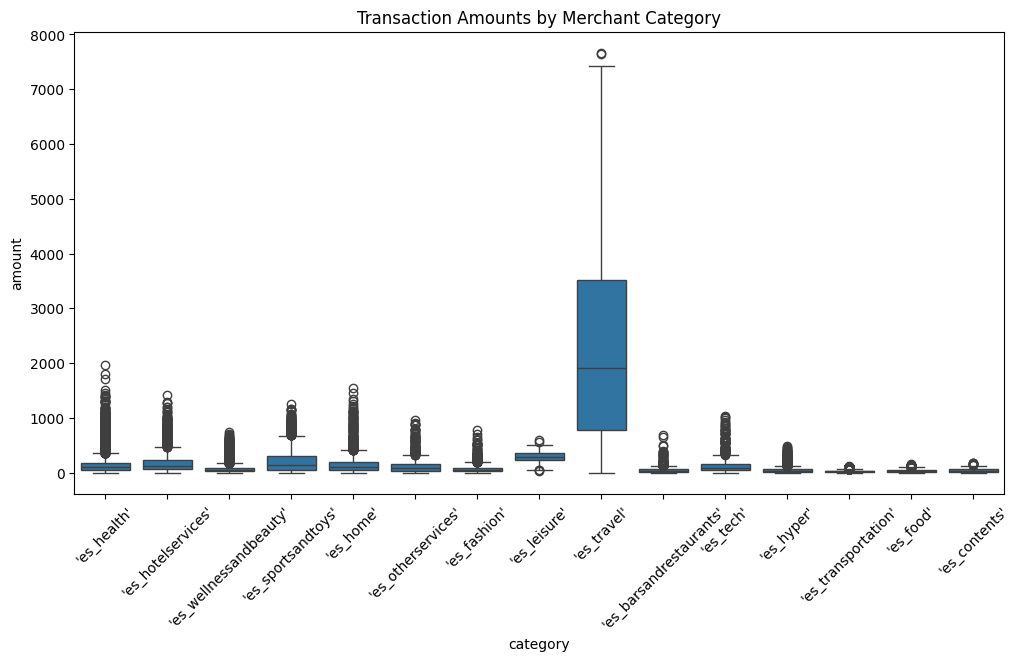

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='amount', data=df)
plt.title('Transaction Amounts by Merchant Category')
plt.xticks(rotation=45)
plt.show()

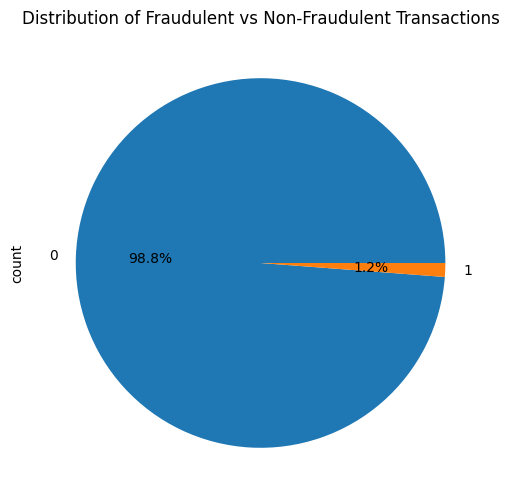

In [4]:
plt.figure(figsize=(8, 6))
df['fraud'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

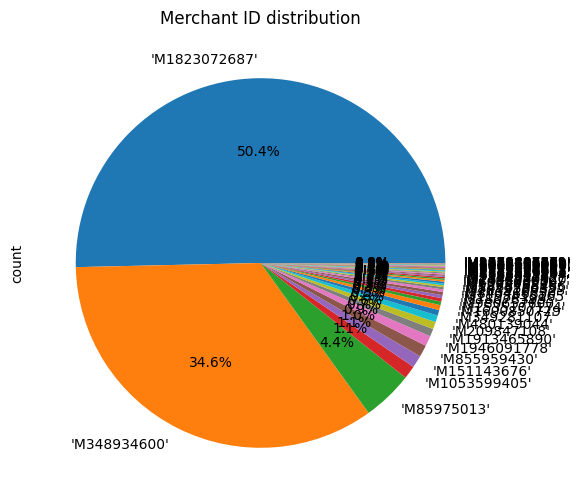

In [5]:
plt.figure(figsize=(8, 6))
df['merchant'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Merchant ID distribution')
plt.show()

In [6]:
Ori_values = df['zipcodeOri'].unique()
Mer_values = df['zipMerchant'].unique()
print(f"{Ori_values}, {Mer_values}")

["'28007'"], ["'28007'"]


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
import warnings
warnings.filterwarnings("ignore")


In [9]:
columns_to_drop = ['step', 'customer', 'zipcodeOri', 'zipMerchant']
df = df.drop(columns=columns_to_drop)
df['age'] = df['age'].replace("'U'", np.nan).str.replace("'", "").astype(float)
df['age'] = df['age'].fillna(df['age'].median())

In [10]:
le = LabelEncoder()
categorical_columns = ['gender', 'merchant', 'category']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

scaler = StandardScaler()
df['amount'] = scaler.fit_transform(df[['amount']])

In [11]:
X = df.drop('fraud', axis=1)
y = df['fraud']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [13]:
xgb_model = XGBClassifier(
    colsample_bytree=1.0, learning_rate=0.3, max_depth=10, n_estimators=600,
    subsample=1.0, gamma=2.0, min_child_weight=1, tree_method='gpu_hist',
    use_label_encoder=False
)
lgbm_model = LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=10)

stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=XGBClassifier(
        colsample_bytree=1.0, learning_rate=0.3, max_depth=10, n_estimators=600,
        subsample=1.0, gamma=2.0, min_child_weight=1, tree_method='gpu_hist',
        use_label_encoder=False
    )
)

stacking_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 405858, number of negative: 406050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 811908, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499882 -> initscore=-0.000473
[LightGBM] [Info] Start training from score -0.000473
[LightGBM] [Info] Number of positive: 324686, number of negative: 324840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 649526, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499881 -> initscore=-0.000474


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=2.0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_ra...
                                                 feature_types=None, gamma=2.0,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.3,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=10, max_leaves=None,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=600, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [14]:
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_f1 = 0
for threshold in thresholds:
    y_pred_stacking = (y_pred_proba_stacking >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_stacking)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

In [15]:
y_pred_stacking = (y_pred_proba_stacking >= best_threshold).astype(int)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
auc_roc_stacking = roc_auc_score(y_test, y_pred_proba_stacking)

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()

In [18]:
print("Stacking Classifier:")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"AUC-ROC: {auc_roc_stacking:.4f}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"True Positive Rate (TPR) / Recall: {recall_stacking:.4f}")
print(f"False Positive Rate (FPR): {fp / (fp + tn):.4f}")

Stacking Classifier:
Precision: 0.9796
Recall: 0.9915
F1 Score: 0.9855
AUC-ROC: 0.9987
True Negatives (TN): 99293
False Positives (FP): 2100
False Negatives (FN): 862
True Positives (TP): 100723
True Positive Rate (TPR) / Recall: 0.9915
False Positive Rate (FPR): 0.0207
